In [1]:
"""
AR(1) model using default LLY method
"""
import numpy as np
import pandas as pd
import linkalman
import scipy
from linkalman.models import BaseConstantModel as BCM
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline 



/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Model Specification
The motivation of adding noises to measurements is that in the real world, we are dealing with samples, not populations. In addition, we may not be able to observe all the desired measurements. Sensors may fail, and data may be collected at different intervals. In addition, companies doing experiments are interested in finding the counterfactuals. This examples shows how `linkalman` handles such situations.

In [2]:
def my_f(theta):
    """
    AR(1) model. In general, MLE is biased, so the focus should be 
    more on prediction fit, less on parameter estimation. The 
    formula here for Ar(1) is:
    y_t = c + Fy_{t-1} + epsilon_{t-1}
    """
    # Define theta
    phi_1 = 1 / (np.exp(theta[0])+1)  # ensure less than 1
    sigma = np.exp(theta[1]) 
    sigma_R = np.exp(theta[2])
    # Generate F
    F = np.array([[phi_1]])
    # Generate Q
    Q = np.array([[sigma]]) 
    # Generate R, set to 0 to be consistent with AR(1) process
    R = np.array([[sigma_R]])
    # Generate H
    H = np.array([[1]])
    # Generate B
    B = np.array([[theta[3]]])
    # Collect system matrices
    M = {'F': F, 'Q': Q, 'H': H, 'R': R, 'B': B}

    return M


In [3]:
def my_solver(param, obj_func, **kwargs):
    """
    Simple solver for LLY
    """
    obj_ = lambda x: -obj_func(x)
    res = minimize(obj_, param, **kwargs)
    theta_opt = np.array(res.x)
    fval_opt = res.fun
        
    return theta_opt, fval_opt

In [4]:
# Initialize the model
x = 1  # used to calculate stationary mean
model = BCM()
model.set_f(my_f, x_0=x * np.ones([1, 1]))
model.set_solver(my_solver, method='nelder-mead', 
        options={'xatol': 1e-8, 'disp': True}) 

# Generate Synthetic Data
Same as the standard setup, but I cross off some measurements during training period and see how `linkalman` handles them. 

In [5]:
# Some initial parameters
theta = np.array([-1, -0.1, 0.1, 1])
T = 365
train_split_ratio = 0.7
forecast_cutoff_ratio = 0.8  

missing_range = [0.3, 0.5]

# Split train data
train_split_t = np.floor(T * train_split_ratio).astype(int)

# Generate missing data for forcasting
forecast_t = np.floor(T * forecast_cutoff_ratio).astype(int)

# If we want AR(1) with non-zero stationary mean, we should proivde a constant 
x_col = ['const']
Xt = pd.DataFrame({x_col[0]: x * np.ones(T)})  # use x to ensure constant model

# Build simulated data
df, y_col, xi_col = model.simulated_data(input_theta=theta, Xt=Xt)

# Store fully visible y for comparison later
df['y_0_vis'] = df.y_0.copy()  

# Insert some missingness
missing_start_t = np.floor(T * missing_range[0]).astype(int)
missing_end_t = np.floor(T * missing_range[1]).astype(int)
is_missing = (df.index >= missing_start_t) & (df.index < missing_end_t)
df.loc[is_missing, ['y_0']] = np.nan

# Splits models into three groups
is_train = df.index < train_split_t
is_test = (~is_train) & (df.index < forecast_t)
is_forecast = ~(is_train | is_test)

# Create a training and test data
df_train = df.loc[is_train].copy()

# Build two kinds of test data (full data vs. test data only)
df_test = df.copy()  
df_test_only = df.loc[is_test | is_forecast].copy()  

# Create an offset
df_test.loc[is_forecast, ['y_0']] = np.nan
df_test_only.loc[df_test_only.index >= forecast_t, ['y_0']] = np.nan

# Fit and Predict

In [6]:
# Fit data using LLY:
theta_init = np.random.rand(len(theta))
model.fit(df_train, theta_init, y_col=y_col, x_col=x_col, 
              method='LLY')

Optimization terminated successfully.
         Current function value: 364.099047
         Iterations: 242
         Function evaluations: 436


# Check Model Performance
Since we introduce missing measurements and measurement errors, we can also check the distribution of $y_t$ conditioned on all ovserved values.

In [7]:
# Generate upper and lower bounds
# Make predictions from LLY:
df_LLY = model.predict(df_test)
df_LLY['yf_ub'] = df_LLY.y_0_filtered + 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['yf_lb'] = df_LLY.y_0_filtered - 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['ys_ub'] = df_LLY.y_0_smoothed + 1.96 * np.sqrt(df_LLY.y_0_svar)
df_LLY['ys_lb'] = df_LLY.y_0_smoothed - 1.96 * np.sqrt(df_LLY.y_0_svar)
df_LLY['xif_ub'] = df_LLY.xi_0_filtered + 1.96 * np.sqrt(df_LLY.P_0_filtered)
df_LLY['xif_lb'] = df_LLY.xi_0_filtered - 1.96 * np.sqrt(df_LLY.P_0_filtered)
df_LLY['xis_ub'] = df_LLY.xi_0_smoothed + 1.96 * np.sqrt(df_LLY.P_0_smoothed)
df_LLY['xis_lb'] = df_LLY.xi_0_smoothed - 1.96 * np.sqrt(df_LLY.P_0_smoothed)

# Make predictions using true theta:
df_true = model.predict(df_test, theta=theta)
df_true['yf_ub'] = df_true.y_0_filtered + 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['yf_lb'] = df_true.y_0_filtered - 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['ys_ub'] = df_true.y_0_smoothed + 1.96 * np.sqrt(df_true.y_0_svar)
df_true['ys_lb'] = df_true.y_0_smoothed - 1.96 * np.sqrt(df_true.y_0_svar)

# Create some plotting functions (of course you can go very fancy with the model ou)
def simple_plot(df, col_est, col_actual, col_ub, col_lb, label_est,
                label_actual, title, figsize=(20, 10)):
    ax = plt.figure(figsize=figsize)
    plt.plot(df.index, df[col_est], 'r', label=label_est)
    plt.scatter(df_LLY.index, df[col_actual], s=20, c='b', 
                marker='o', label=label_actual)
    plt.fill_between(df.index, df[col_ub], df[col_lb], color='g', alpha=0.2)
    ax.legend(loc='right', fontsize=12)
    plt.title(title, fontsize=22)
    plt.show()

Here I plot the filtered and smoothed $y_t$, $\hat{\xi}_{t|T}$ and $\hat{\xi}_{t|t-1}$ from the fitted $\theta$. As you can see, the smoothed model produced a much narrower confidence interval around $\xi_t$.

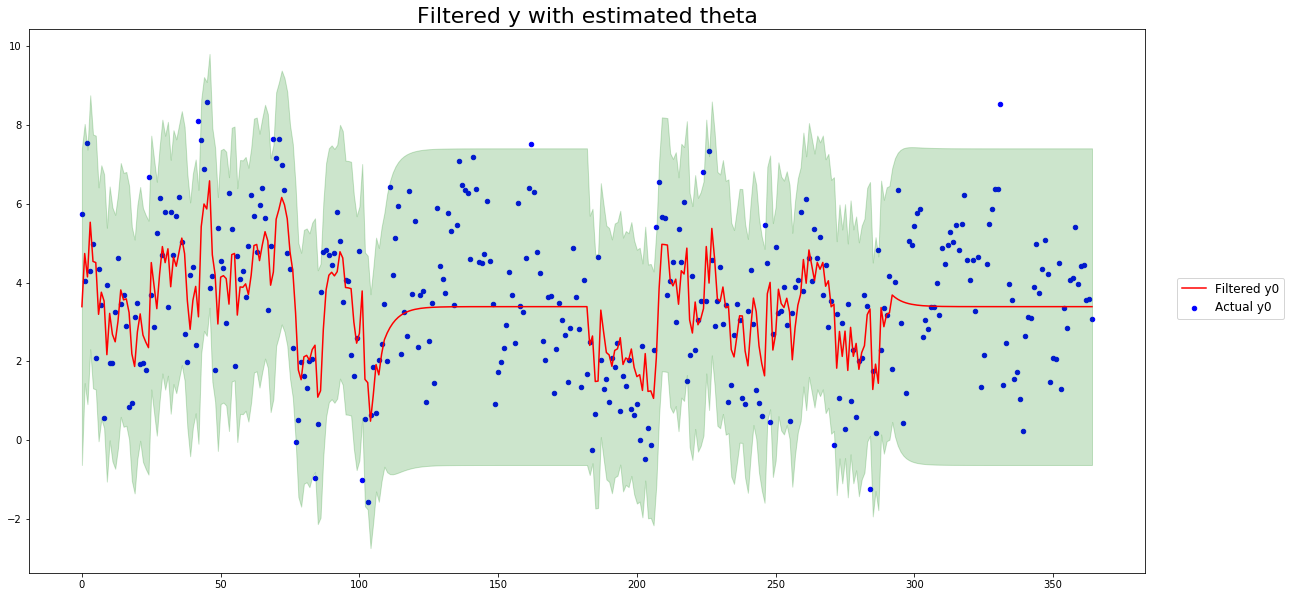

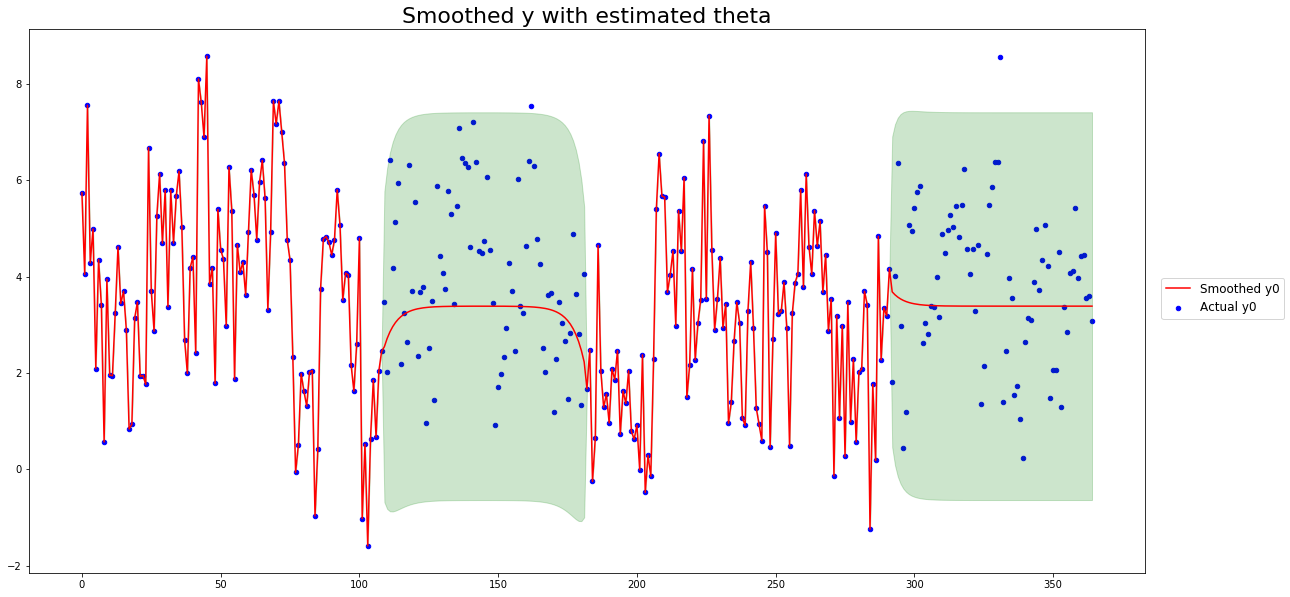

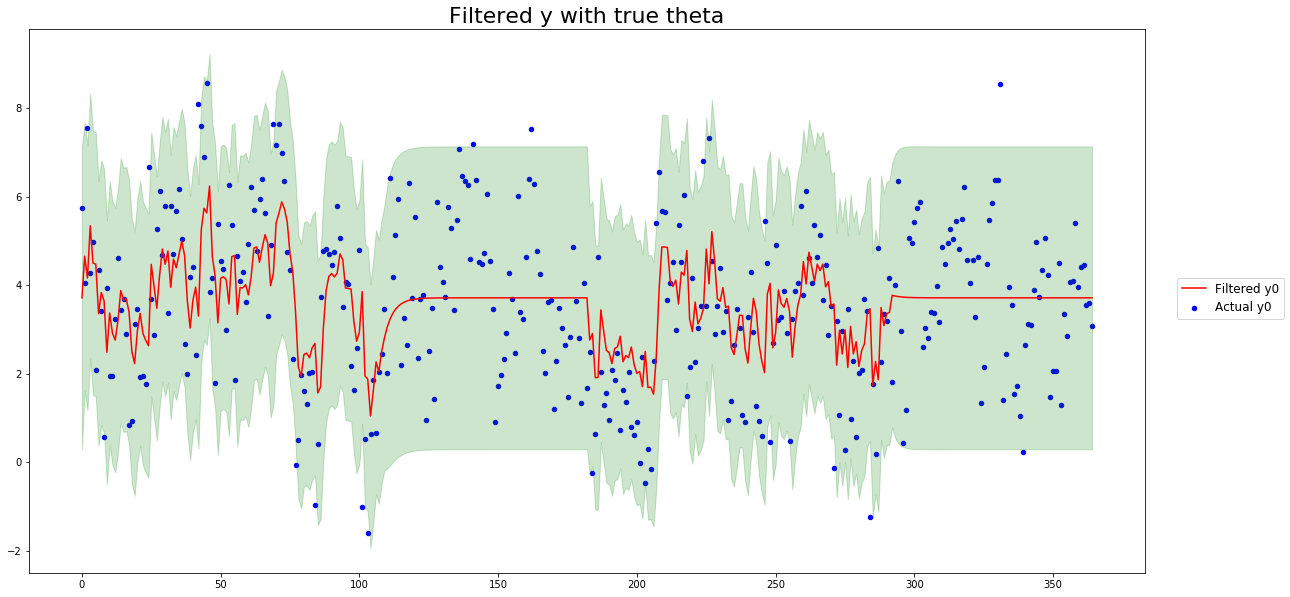

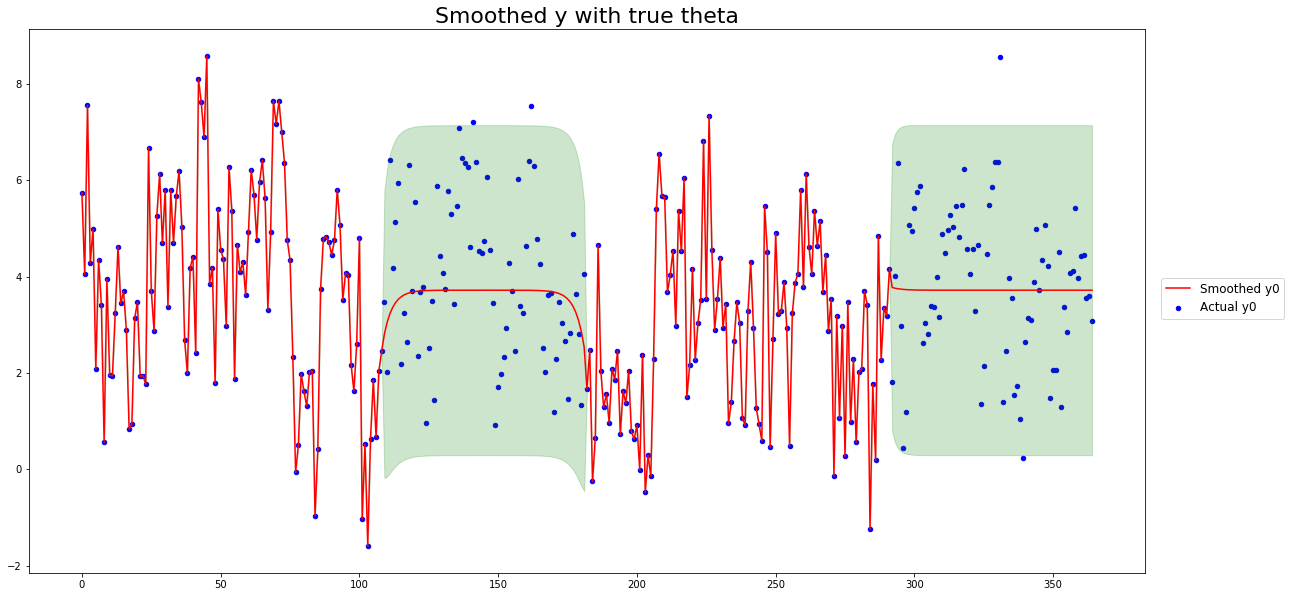

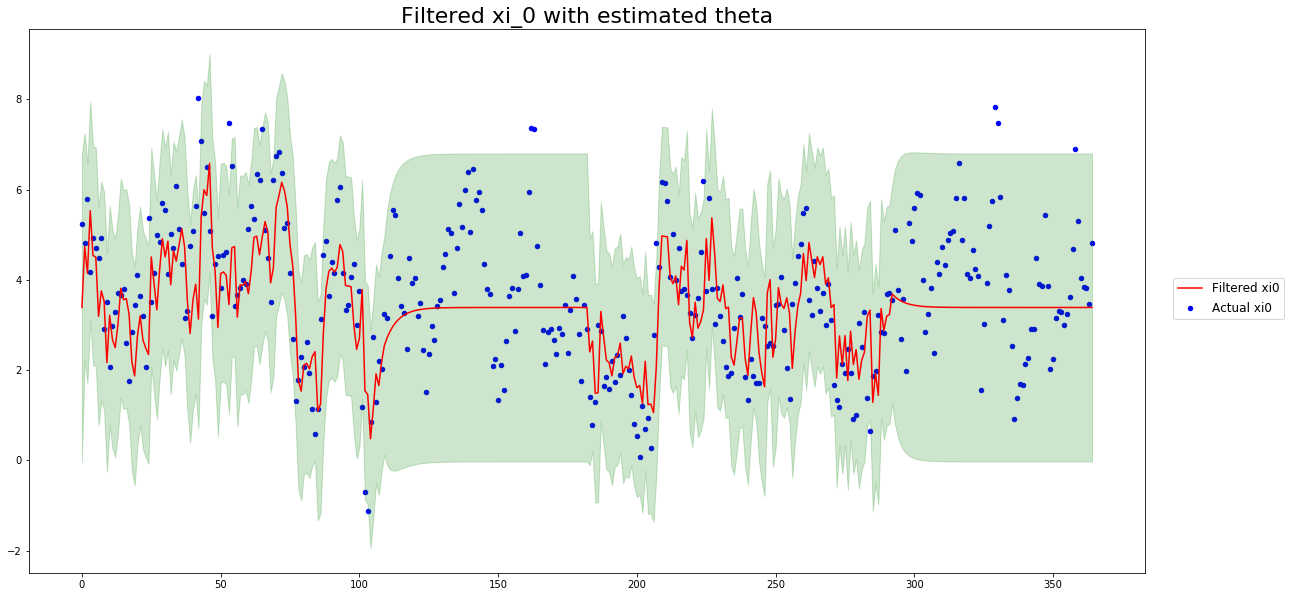

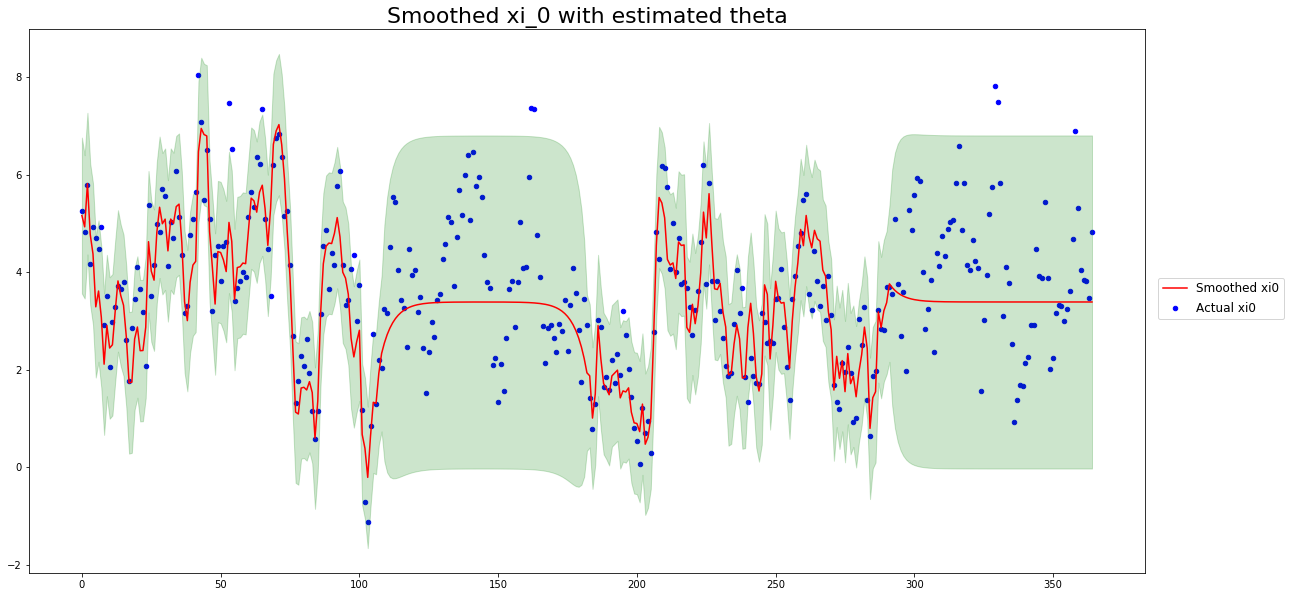

In [8]:
# y_t with estimated theta
simple_plot(df_LLY, 'y_0_filtered', 'y_0_vis', 'yf_ub', 'yf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with estimated theta')
simple_plot(df_LLY, 'y_0_smoothed', 'y_0_vis', 'ys_ub', 'ys_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y with estimated theta')

# y_t with true theta
simple_plot(df_true, 'y_0_filtered', 'y_0_vis', 'yf_ub', 'yf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with true theta')
simple_plot(df_true, 'y_0_smoothed', 'y_0_vis', 'ys_ub', 'ys_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y with true theta')

# xi_t
simple_plot(df_LLY, 'xi_0_filtered', 'xi_0', 'xif_ub', 'xif_lb', 'Filtered xi0', 'Actual xi0',
           'Filtered xi_0 with estimated theta')
simple_plot(df_LLY, 'xi_0_smoothed', 'xi_0', 'xis_ub', 'xis_lb', 'Smoothed xi0', 'Actual xi0',
           'Smoothed xi_0 with estimated theta')